# 8.9 使用正则化缓解过拟合


### 1.任务描述

在文件/project08/dot.csv中，有3列数据，$x_1,x_2$，y_c，其中，$x_1$和$x_2$是样本特征；y_c是样本标签，取值为0或1。

要求：

1. 构建一个神经网络，拟合输入特征（$x_1$和$x_2$）与标签y_c的关系
2. 要求将新的数据$x_1$和$x_2$送入神经网络，网络经过前向传播，输出预测值，自动判断是为1的可能性大，还是为0的可能性大
3. 把$x_1$、$x_2$分别作为横、纵坐标，将数据可视化输出，标签为1的，为星形点；标签为0的，为x形点
4. 根据模型的输出，绘制出一条线，区分星形点和x形点

### 2.知识准备

见教程。
   

### 3.任务分析

先用神经网络拟合出特征$x_1$和$x_2$与标签的函数关系，然后生成网络，覆盖这些点，把网络的交点（横、纵坐标）作为输入，送入训练好的神经网络，网络会为每个坐标输出一个预测值。

要区分输出是偏向1还是偏向0，可以把神经网络输出预测值为0.5的线标出颜色，这条线就是0（x形点）和1（星形点）的分界线。

### 4.任务实施


执行代码

epoch: 0 loss: 5.162293434143066
epoch: 50 loss: 0.5135178565979004
epoch: 100 loss: 0.39526358246803284
epoch: 150 loss: 0.3174248933792114
epoch: 200 loss: 0.26262301206588745
epoch: 250 loss: 0.22386202216148376
epoch: 300 loss: 0.19726844131946564
epoch: 350 loss: 0.17903214693069458
epoch: 400 loss: 0.16709265112876892


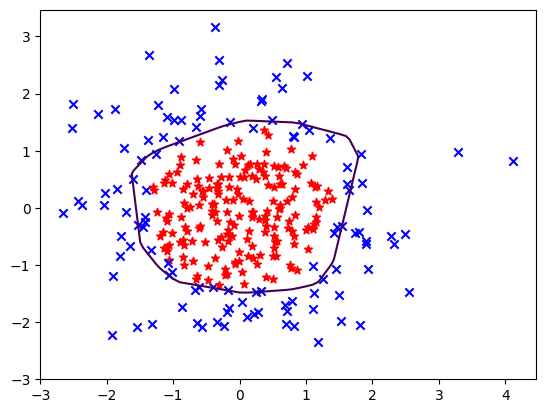

In [4]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# 1，数据处理
# 读取数据
df = pd.read_csv('dot.csv')
x_data = np.array(df[['x1', 'x2']])
y_data = np.array(df['y_c']).reshape(-1, 1)
# 转换类型
x_train = tf.cast(x_data, tf.float32)
y_train = tf.cast(y_data, tf.float32)

# 标签为1标为星形，标签为0标为x形
Y_m = [['*' if y else 'x'] for y in y_train]

# 生成数据集
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)

# 2，参数设置
# 参数初始化
w1 = tf.Variable(tf.random.normal([2, 11]), dtype=tf.float32)
b1 = tf.Variable(tf.constant(0.01, shape=[11]), dtype=tf.float32)
w2 = tf.Variable(tf.random.normal([11, 1]), dtype=tf.float32)
b2 = tf.Variable(tf.constant(0.01, shape=[1]), dtype=tf.float32)
# 超参数
lr = 0.01
epoch = 400
REGULARIZER = 0.03
# 3，训练
for epoch in range(epoch+1):
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:
            # 第一层线性结果
            h1 = tf.matmul(x_train, w1) + b1 
            # 第一层激活函数
            h1 = tf.nn.relu(h1)
            # 第二层线性结果
            y = tf.matmul(h1, w2) + b2            
            # 3.1，不使用正则化
            # start1
            # loss = tf.reduce_mean(tf.square(y_train - y))
            # end1            
   
            # 3.2，使用L2正则化
            # start2
            loss_mse = tf.reduce_mean(tf.square(y_train - y)) 
            loss_regularization = []
            loss_regularization.append(tf.keras.regularizers. l2(REGULARIZER)(w1))
            loss_regularization.append(tf.keras.regularizers. l2(REGULARIZER)(w2))
            loss_regularization = tf.reduce_sum(loss_regularization)
            loss = loss_mse + loss_regularization 
            # end2            
            
        # 计算Loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1, w2, b2])
        w1.assign_sub(lr * grads[0]) 
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])

    # 打印每200个epoch的Loss信息
    if epoch % 50 == 0:
        print('epoch:', epoch, 'loss:', float(loss))
        
# 4，预测
# 生成网格坐标点
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
# 将xx, yy拉直，合并配对为二维张量，生成二维坐标点
grid = np.c_[xx.ravel(), yy.ravel()]
grid = tf.cast(grid, tf.float32)
# 进行预测，probs为输出
probs = []
for x_predict in grid:
    # 使用训练好的参数进行预测
    h1 = tf.matmul([x_predict], w1) + b1
    h1 = tf.nn.relu(h1)
    y = tf.matmul(h1, w2) + b2
    probs.append(y)

# 5，可视化
# 输出样本特征数据散点图
x1 = x_data[:,0]
x2 = x_data[:,1]
Y_m = np.squeeze(Y_m)
for i in range(len(x1)):
    if (Y_m[i] == '*'):
        plt.scatter(x1[i], x2[i], marker=Y_m[i],c='r')
    else:
        plt.scatter(x1[i], x2[i], marker=Y_m[i],c='b')
# 基于xx、yy和对应的值probs绘制等高线，给probs值为0.5的点上色，作为x形点与星形点的分界线
probs = np.array(probs).reshape(xx.shape)
plt.contour(xx, yy, probs, levels=[.5])
plt.show()